# Lets start off by performing similarity search for images

In [1]:
import numpy as np
import imageio
from skimage import transform
import matplotlib.pyplot as plt
from math import sqrt
import glob
import subprocess

%matplotlib inline

In [2]:
def load_image(img_path, resize=True):
    tmp_img = imageio.imread(img_path)
    if resize:
        return transform.resize(image=tmp_img,output_shape=(200,200),anti_aliasing=True, mode='constant')
    return tmp_img

Let us look at 3 different pictures of golden retriever puppies (Google images found these to be similar)

In [3]:
img1 = load_image("data/images/golden1.jpg")
img2 = load_image("data/images/golden2.jpg")
img3 = load_image("data/images/golden3.jpg")

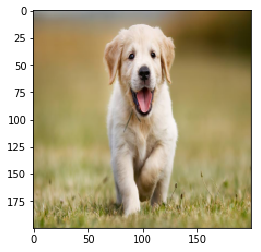

In [4]:
plt.imshow(img1)

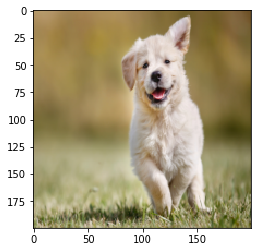

In [5]:
plt.imshow(img2)

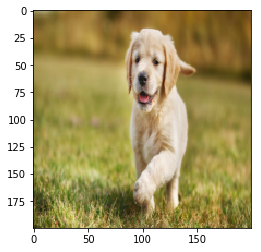

In [6]:
plt.imshow(img3)

In [7]:
def mse_image(image1,image2):
    return sqrt(np.mean((image1-image2)**2))

In [8]:
print(mse_image(img1,img2))
print(mse_image(img2,img3))
print(mse_image(img3,img1))

0.19022686342926862
0.18840959325910303
0.18147532920332463


In [9]:
from skimage.measure import compare_ssim as ssim

In [10]:
print(ssim(img1,img2,multichannel=True))
print(ssim(img2,img3,multichannel=True))
print(ssim(img3,img1,multichannel=True))

0.5622781046149279
0.5310086838617171
0.5215860201451067


We know that `SSIM` (Structural Similarity) is robust to noise and contrast changes unlike `MSE` (Mean Square Error)

In [11]:
# MSE is faster than SSIM
%timeit mse_image(img1,img2)
%timeit ssim(img1,img2,multichannel=True)

133 µs ± 3.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.44 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For the $200\times200$ image, the MSE took 130 $\mu$s while SSIM took 6.68 ms i.e. MSE was $50\times$ faster.

# Dominant color

In [12]:
import dominant_cluster
%timeit dcolors = dominant_cluster.get_dom_colors("data/images/golden1.jpg",clusters=10)

18.3 s ± 2.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import kmeans_gpu
%timeit dcolors, bar_img = kmeans_gpu.run("data/images/golden1.jpg",clusters=10)
!nvidia-smi

293 ms ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Thu Dec 13 16:57:33 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P2    27W /  N/A |    707MiB /  6078MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:          

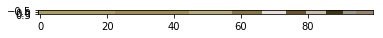

In [14]:
dcolors, bar_img = kmeans_gpu.run("data/images/golden1.jpg",clusters=10)
plt.imshow(bar_img)

We get such a $1\times100$ image for each of the images we cluster i.e. we cluster a resized image of size $200\times200$ and create a smaller image of size $100$ ($0.25\%$) that contains its dominant colors in descending order of dominance. 

The next step is to concatenate these 100 pixel images for each frame (samples at $n$ fps from the video of length $l$ seconds) to create a new image of size $l\times n \times100$ pixel image that will represent the entire video.

This compressed image representation is thereafter used to find similar images using either the **MSE** or **SSIM** similarity metric or by using the **KNN** algorithm.

https://stackoverflow.com/questions/10957412/fastest-way-to-extract-frames-using-ffmpeg

# Vid2Img Representation

In [3]:
!sh extractNFrames.sh data/videos/animals/1.mp4 20

In [19]:
%timeit !ffmpeg -loglevel panic -i data/videos/animals/0.mp4 -vf scale="426x240" -r 1  data/tmp/output_%01d.jpg

181 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
num_of_frames = 20
def cluster_vid(vid_path):
#     !ffmpeg -i input.mp4 -r 1 -q:v 1 -qmax 1 data/tmp/output_%01d.jpg
    p = subprocess.Popen("sh extractNFrames.sh "+vid_path+" "+str(num_of_frames), stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    frame_list = glob.glob('data/tmp/*.jpg')
    vid_img = None
    for fr in frame_list:
        _, bar_img = kmeans_gpu.run(fr,clusters=10)
        if type(vid_img) is not np.ndarray:
            vid_img = bar_img
        else:
            vid_img = np.concatenate((vid_img, bar_img), axis=0)
    return vid_img

In [18]:
%time vid_img = cluster_vid("data/videos/animals/0.mp4")

CPU times: user 34.6 s, sys: 4.02 s, total: 38.6 s
Wall time: 7.57 s


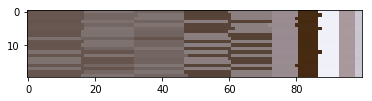

In [29]:
imageio.imwrite("data/vid2img/vid_name.jpg",vid_img)
plt.imshow(vid_img)

In [19]:
classes = sorted([path.split("/")[-1] for path in glob.glob("data/videos/*")])
print(classes)

['animals', 'children', 'christmas', 'nature', 'school', 'snow', 'work']


In [20]:
%%time 
for cl in classes:
    vid_list = sorted(glob.glob('data/videos/'+cl+'/*'))
    for i,vid_path in enumerate(vid_list):
        vid_img = cluster_vid(vid_path)
        imageio.imwrite("data/vid2img/"+cl+"_"+str(i)+".jpg",vid_img)

CPU times: user 40min 42s, sys: 5min 29s, total: 46min 11s
Wall time: 7min 17s


**Thus we see that for $10\times7 = 70$ videos, the process took $437$ seconds to execute i.e. approx $6.2$ seconds for video. This process includes:**
1. **Extracting frames from videos and writing them to disk.**
2. **Clustering the extracted frames (20 per video).**
3. **Converting the histogram of clusters into an image and writing to disk.**

# KNN search using Vid2Img

In [21]:
import knn_vidimg
vid2img_list = sorted(glob.glob('data/vid2img/*.jpg'))

In [22]:
%time vidIndices = knn_vidimg.run_knn_vid2img(vid2img_list,k=3)

Number of records: 70 
Number of dimensions: 6000
Running with Flat index for 70 records of with dimensionality 6000
CPU times: user 42.2 ms, sys: 92.1 ms, total: 134 ms
Wall time: 132 ms


The dimensionality is $6000$ since ($20\times100 = 2000$ pixels and RBG (3) values for each pixel).

The runtime for the KNN search with $k = 3$ (build *and* run on all videos) for this subset of $70$ videos is $132$ms and we can be sure that this will scale effectively based on previous experiments.

*Let us look at the values (for the first video):*

In [23]:
print(vid2img_list[0],":",[vid2img_list[i] for i in vidIndices[0]])

data/vid2img/animals_0.jpg : ['data/vid2img/animals_0.jpg', 'data/vid2img/animals_1.jpg', 'data/vid2img/children_9.jpg']


The videos animals_0.mp4 appears in the results as the closest and this is obvious. The other two videos are a monkey and a cat respectively. It did not care about context - only color.